Imports & Instantiations

In [6]:
%load_ext autoreload
%autoreload 2
from market_data_loader import MarketDataLoader
from oms import OrderManagementSystem
from order_book import LimitOrderBook
from position_tracker import PositionTracker
from strategies.trend_following   import run_backtest as tf_backtest
from strategies.mean_reversion    import run_backtest as mr_backtest
from strategies.arbitrage         import run_backtest as arb_backtest
from order import Order
import pandas as pd

loader = MarketDataLoader(interval="1d", period="1mo")
oms = OrderManagementSystem()
tracker = PositionTracker()
book = LimitOrderBook("AAPL")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Fetch Data & Generate Signals

In [7]:
hist = loader.get_history("AAPL", 
                          start="2000-06-01", 
                          end="2025-07-01")

signals, trades, metrics = tf_backtest(hist, short_win=10, long_win=50, risk_params={"max_pos":100})

print(f"Generated {len(signals)} signals")
print(f"Executed {len(trades)} trades")
print(f"Sample signal:")
print(signals.head())

[*********************100%***********************]  1 of 1 completed

Generated 161 signals
Executed 161 trades
Sample signal:
Price                      last_price      high       low      open  \
Date                                                                  
2000-08-10 00:00:00+00:00    0.714726  0.727874  0.711908  0.721300   
2000-08-28 00:00:00+00:00    0.872510  0.886598  0.857483  0.860301   
2000-09-29 00:00:00+00:00    0.386947  0.435786  0.381312  0.423576   
2001-01-18 00:00:00+00:00    0.280818  0.281757  0.264852  0.267670   
2001-05-30 00:00:00+00:00    0.297236  0.311962  0.290023  0.311962   

Price                          volume  ma_short   ma_long  signal  prev_signal  
Date                                                                            
2000-08-10 00:00:00+00:00   251714400  0.722521  0.762522      -1          0.0  
2000-08-28 00:00:00+00:00   359004800  0.787584  0.781310       1         -1.0  
2000-09-29 00:00:00+00:00  7421640800  0.786880  0.796070      -1          1.0  
2001-01-18 00:00:00+00:00  1227010400  0

Simulate Orders & Executions

In [8]:
# The tf_backtest function already executed all trades internally
# The 'trades' variable contains the execution reports
# For demonstration, let's process them through our notebook's tracker

for trade in trades:
    # trades are already execution reports in the correct format
    tracker.update(trade)

print(f"Processed {len(trades)} trades through tracker")

Processed 161 trades through tracker


Compile and Plot P&L

Blotter has 161 entries
Sample blotter entries:
                  timestamp symbol  side  quantity     price  cash_flow  \
0 2000-08-10 00:00:00+00:00   AAPL  sell       100  0.714726  71.472567   
1 2000-08-28 00:00:00+00:00   AAPL   buy       100  0.872510 -87.251043   
2 2000-09-29 00:00:00+00:00   AAPL  sell       100  0.386947  38.694727   
3 2001-01-18 00:00:00+00:00   AAPL   buy       100  0.280818 -28.081837   
4 2001-05-30 00:00:00+00:00   AAPL  sell       100  0.297236  29.723564   

     cum_pnl  
0  71.472567  
1 -15.778476  
2  22.916251  
3  -5.165586  
4  24.557978  


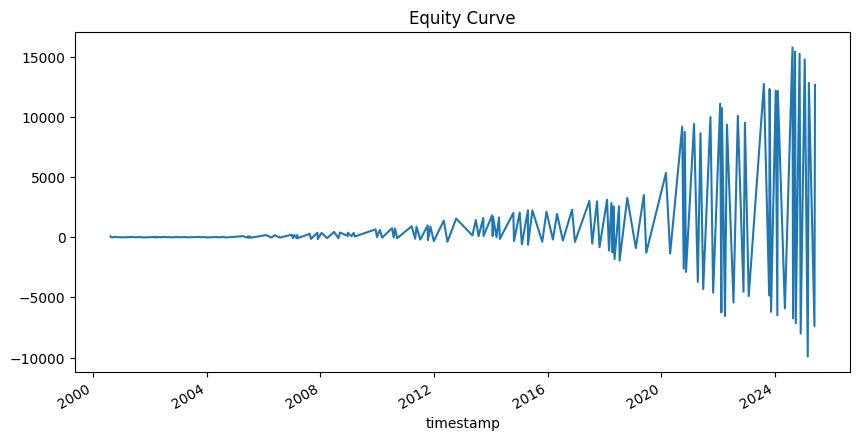

In [9]:
blotter = tracker.get_blotter()  # DataFrame with columns: timestamp, symbol, side, quantity, price, cash_flow

if not blotter.empty:
    blotter["cum_pnl"] = blotter["cash_flow"].cumsum()
    blotter.set_index("timestamp")["cum_pnl"].plot(figsize=(10,5), title="Equity Curve")
    
    print(f"Blotter has {len(blotter)} entries")
    print("Sample blotter entries:")
    print(blotter.head())
else:
    print("No trades executed - blotter is empty")

Performance Summary

In [10]:
# Cell 5: Performance Summary
print(f"**Total Return:**  {metrics['total_return']:.2%}")
print(f"**Max Drawdown:**  {metrics['max_drawdown']:.2%}")
print(f"**Sharpe Ratio:**  {metrics['sharpe_ratio']:.2f}")

# Additional summary from the tracker
summary = tracker.get_pnl_summary()
print(f"\n**From Tracker:**")
print(f"Current Cash: ${summary['current_cash']:,.2f}")
print(f"Positions: {summary['positions']}")
print(f"Total PnL: ${summary['total_pnl']:,.2f}")

**Total Return:**  4.78%
**Max Drawdown:**  -22.18%
**Sharpe Ratio:**  -131.22

**From Tracker:**
Current Cash: $12,646.06
Positions: {'AAPL': -100}
Total PnL: $12,646.06
